In [27]:
%pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [29]:
df = pd.read_csv("googleplaystore.csv")
df.head()

,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,07-Jan-18,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,15-Jan-18,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,01-Aug-18,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,08-Jun-18,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,20-Jun-18,1.1,4.4 and up


In [30]:
# print(df)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      10841 non-null  int64  
 1   App             10841 non-null  object 
 2   Category        10841 non-null  object 
 3   Rating          9367 non-null   float64
 4   Reviews         10841 non-null  int64  
 5   Size            10841 non-null  object 
 6   Installs        10841 non-null  object 
 7   Type            10840 non-null  object 
 8   Price           10841 non-null  object 
 9   Content Rating  10841 non-null  object 
 10  Genres          10841 non-null  object 
 11  Last Updated    10841 non-null  object 
 12  Current Ver     10833 non-null  object 
 13  Android Ver     10838 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.2+ MB


In [32]:
df.describe()

,Unnamed: 0,Rating,Reviews
count,10841.000000,9367.000000,1.084100e+04
mean,5420.000000,4.191513,4.441119e+05
std,3129.671468,0.515735,2.927629e+06
min,0.000000,1.000000,0.000000e+00
25%,2710.000000,4.000000,3.800000e+01
50%,5420.000000,4.300000,2.094000e+03
75%,8130.000000,4.500000,5.476800e+04
max,10840.000000,5.000000,7.815831e+07


In [33]:
#performing cleaning
#dimentionality reduction
#removing Last Updated, Android Version, and Current Version because these values are not related to our task of predicting rating
dropColumnsList=['Last Updated','Android Ver','Current Ver']
df=df.drop(dropColumnsList,axis=1)
print("Deleted columns : Last Updated, Android Version, Current Version")

Deleted columns : Last Updated, Android Version, Current Version


In [34]:
# drop row at which 'Installs' is 'Free'
df.drop(df[df['Installs']=='Free'].index, inplace=True)

In [35]:
# Convert the 'Installs' values to integer value
def convert_installs(installs):
    new_install=installs.replace(',','')
    new_install=new_install.replace('+','')
    new_install=int(new_install)
    return new_install



In [36]:
df['Installs'] = df['Installs'].map(convert_installs)

In [37]:
#remove rows containing null values in these columns list
arr=['Rating','Category','Reviews','Installs','Type','Price','Genres']
df.dropna(subset=arr, inplace=True)
print("Removed null values from columns : " + ",".join(arr)) 

Removed null values from columns : Rating,Category,Reviews,Installs,Type,Price,Genres


In [38]:
print("Null values in each column : ") 
df.isnull().sum()

Null values in each column : 


Unnamed: 0        0
App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
dtype: int64

In [39]:
# Change 'Price' to float by removing unncecessary characters
df['Price'] = df['Price'].map(lambda x: x.replace('$',''))

In [40]:
# Convert columns to required data types
df['Rating'] = df['Rating'].astype(float)
df['Reviews'] = df['Reviews'].astype(int)
df['Price'] = df['Price'].astype(float)

In [41]:
# Function to convert size to float
def convert_size(size):
    if size[-1]=='M':
        return float(size[:-1])
    elif size[-1]=='k':
        return float(size[:-1])/1024
    return None

In [42]:
df['Size'] = df['Size'].map(convert_size)

In [43]:
# Calculate the mean size for each category
mean_sizes = df.groupby('Category')['Size'].mean()
print("Mean size for each category : ")
print(mean_sizes)

Mean size for each category : 
Category
ART_AND_DESIGN         12.766102
AUTO_AND_VEHICLES      21.541211
BEAUTY                 15.513514
BOOKS_AND_REFERENCE    14.386035
BUSINESS               14.911458
COMICS                 13.157721
COMMUNICATION          12.457175
DATING                 18.312717
EDUCATION              20.761424
ENTERTAINMENT          21.853333
EVENTS                 14.432268
FAMILY                 30.152645
FINANCE                18.592823
FOOD_AND_DRINK         24.163095
GAME                   45.340571
HEALTH_AND_FITNESS     24.237586
HOUSE_AND_HOME         17.505357
LIBRARIES_AND_DEMO     12.491710
LIFESTYLE              15.370838
MAPS_AND_NAVIGATION    17.448635
MEDICAL                19.414118
NEWS_AND_MAGAZINES     13.127815
PARENTING              21.579545
PERSONALIZATION        11.631244
PHOTOGRAPHY            17.599222
PRODUCTIVITY           12.899033
SHOPPING               17.111450
SOCIAL                 19.170004
SPORTS                 26.506809
TOO

In [44]:
# Function to fill the missing size values in size by mean of particular category
def fillSizeForNoneValuesOfSize(row):
    if pd.isnull(row['Size']):
        return mean_sizes[row['Category']]
    return row['Size']



In [45]:
# Apply the function to each row
df['Size'] = df.apply(fillSizeForNoneValuesOfSize, axis=1)


In [46]:
# Doing the same above step for 'Content Rating'( but with mode instead of mean)
content_rating_freq=df.groupby('Category')['Content Rating'].apply(lambda x: x.mode().iloc[0])
print("Mode of content rating for each category : ")
print(content_rating_freq)


Mode of content rating for each category : 
Category
ART_AND_DESIGN           Everyone
AUTO_AND_VEHICLES        Everyone
BEAUTY                   Everyone
BOOKS_AND_REFERENCE      Everyone
BUSINESS                 Everyone
COMICS                   Everyone
COMMUNICATION            Everyone
DATING                 Mature 17+
EDUCATION                Everyone
ENTERTAINMENT                Teen
EVENTS                   Everyone
FAMILY                   Everyone
FINANCE                  Everyone
FOOD_AND_DRINK           Everyone
GAME                     Everyone
HEALTH_AND_FITNESS       Everyone
HOUSE_AND_HOME           Everyone
LIBRARIES_AND_DEMO       Everyone
LIFESTYLE                Everyone
MAPS_AND_NAVIGATION      Everyone
MEDICAL                  Everyone
NEWS_AND_MAGAZINES       Everyone
PARENTING                Everyone
PERSONALIZATION          Everyone
PHOTOGRAPHY              Everyone
PRODUCTIVITY             Everyone
SHOPPING                 Everyone
SOCIAL                       

In [47]:
def fill_contentRating(row):
    if pd.isnull(row['Content Rating']):
        return content_rating_freq[row['Category']]
    return row['Content Rating']
df['Content Rating'] = df.apply(fill_contentRating, axis=1)

In [48]:
# dropping rows if 'Category' contains float(only alphabets are allowed)
df.drop(df[df['Category'].map(lambda x: not x.isalpha())].index, inplace=True)

In [49]:
# dropping rows if 'Reviews' contain value other than integer
df.drop(df[df['Reviews'].map(lambda x: not str(x).isdigit())].index, inplace=True)

In [50]:
# drop rows if 'Rating' is greater than 5
df.drop(df[df['Rating']>5].index, inplace=True)

In [51]:
# Convert values in Columns 'Category','Type','Content Rating','Genres' to lower case
df['Category'] = df['Category'].map(lambda x: x.lower())
df['Type'] = df['Type'].map(lambda x: x.lower())
df['Content Rating'] = df['Content Rating'].map(lambda x: x.lower())

In [52]:
# generalization
#Generalizing 'Genres' column by removing the sub-genres
def generalize_genres(genre):
    main_genre=genre.split(';')[0]
    return main_genre
df['Genres']=df['Genres'].map(generalize_genres)


In [53]:
# Discretization
# Discretize the 'Rating' column into 4 bins
def get_rating_text(rating):
    if rating>=4:
        return 'high'
    elif rating>=3:
        return 'medium'
    elif rating>=2:
        return 'low'
    return 'very low'
df['Rating-Text']=df['Rating'].map(get_rating_text)

Word cloud of Categories: 
['beauty' 'business' 'comics' 'communication' 'dating' 'education'
 'entertainment' 'events' 'finance' 'lifestyle' 'game' 'family' 'medical'
 'social' 'shopping' 'photography' 'sports' 'tools' 'personalization'
 'productivity' 'parenting' 'weather']


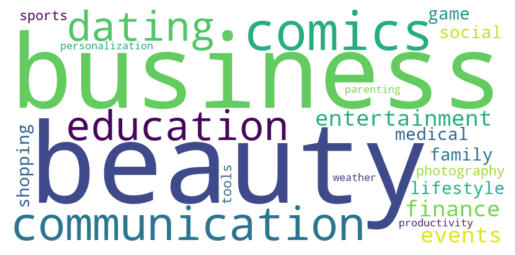

In [54]:
print("Word cloud of Categories: ")
categories_var= df['Category'].unique()
text=" ".join(categories_var)
word_cloud = WordCloud(collocations = False, background_color = 'white',width=800,height=380).generate(text)
print(categories_var)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud of Content Rating: 
['everyone' 'teen' 'mature 17+' 'adults only 18+' 'everyone 10+' 'unrated']


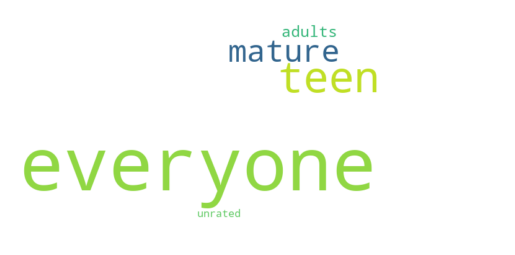

In [55]:
print("Word cloud of Content Rating: ")
content_ratings= df['Content Rating'].unique()
text=" ".join(category for category in df['Content Rating'])
word_cloud = WordCloud(collocations = False, background_color = 'white',width=800,height=380).generate(text)
print(content_ratings)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud of Genres: 
['Beauty' 'Business' 'Comics' 'Communication' 'Dating' 'Education'
 'Entertainment' 'Events' 'Finance' 'Lifestyle' 'Adventure' 'Arcade'
 'Casual' 'Card' 'Action' 'Strategy' 'Puzzle' 'Sports' 'Music' 'Word'
 'Racing' 'Simulation' 'Board' 'Trivia' 'Role Playing' 'Educational'
 'Art & Design' 'Music & Audio' 'Health & Fitness'
 'Video Players & Editors' 'Medical' 'Social' 'Shopping' 'Photography'
 'Tools' 'Personalization' 'Productivity' 'Parenting' 'Weather' 'Casino'
 'Books & Reference' '11-Feb-18']


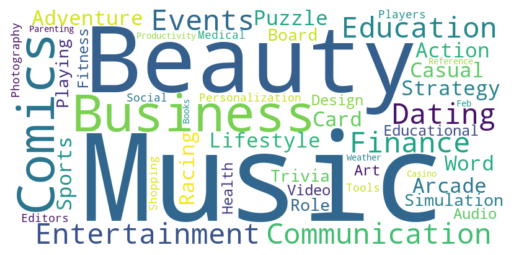

In [56]:
print("Word cloud of Genres: ")
genres_war= df['Genres'].unique()
text=" ".join(genres_war)
word_cloud = WordCloud(collocations = False, background_color = 'white',width=800,height=380).generate(text)
print(genres_war)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

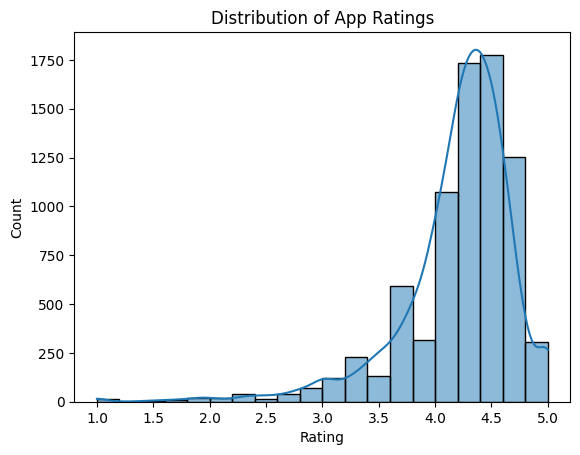

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of App Ratings
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title('Distribution of App Ratings')
plt.show()


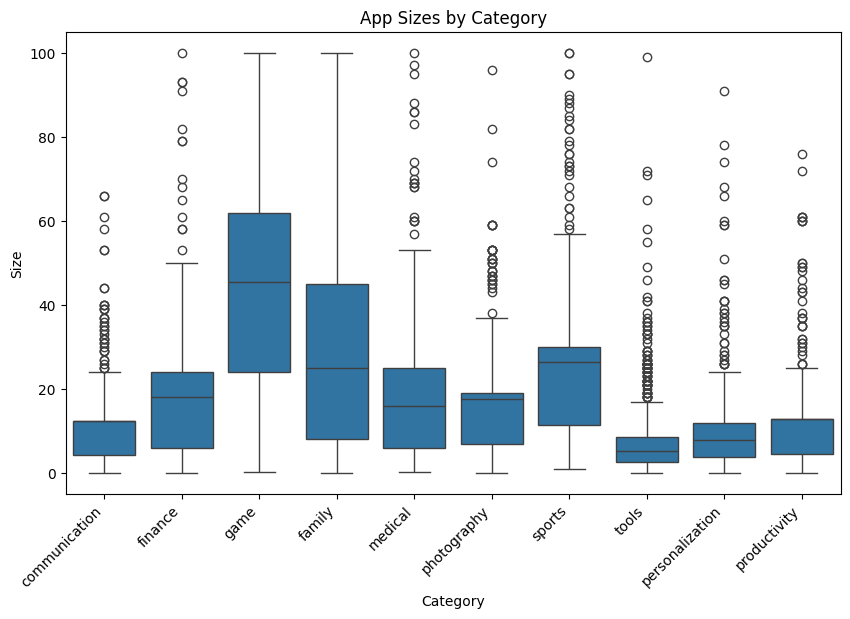

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

top_categories = df['Category'].value_counts().nlargest(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Size', data=df[df['Category'].isin(top_categories)])
plt.title('App Sizes by Category')
plt.xticks(rotation=45, ha='right')
plt.show()


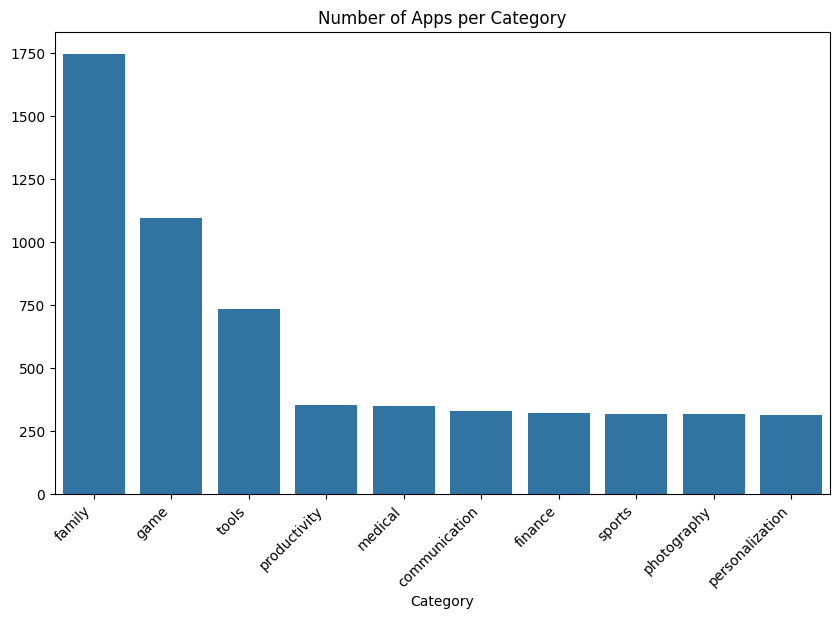

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

category_counts = df['Category'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Number of Apps per Category')
plt.xticks(rotation=45, ha='right')
plt.show()


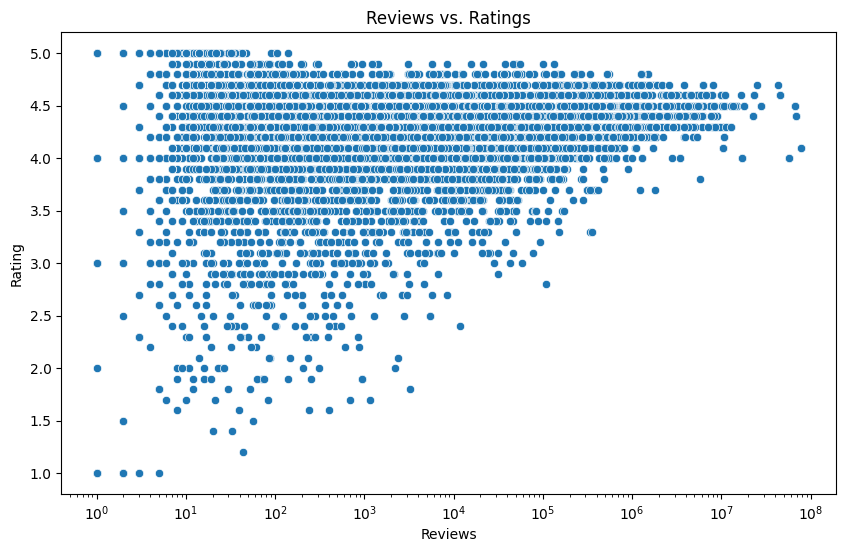

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Reviews', y='Rating', data=df)
plt.title('Reviews vs. Ratings')
plt.xscale('log') # Using log scale due to wide range of Reviews
plt.show()


In [62]:
%pip install squarify

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


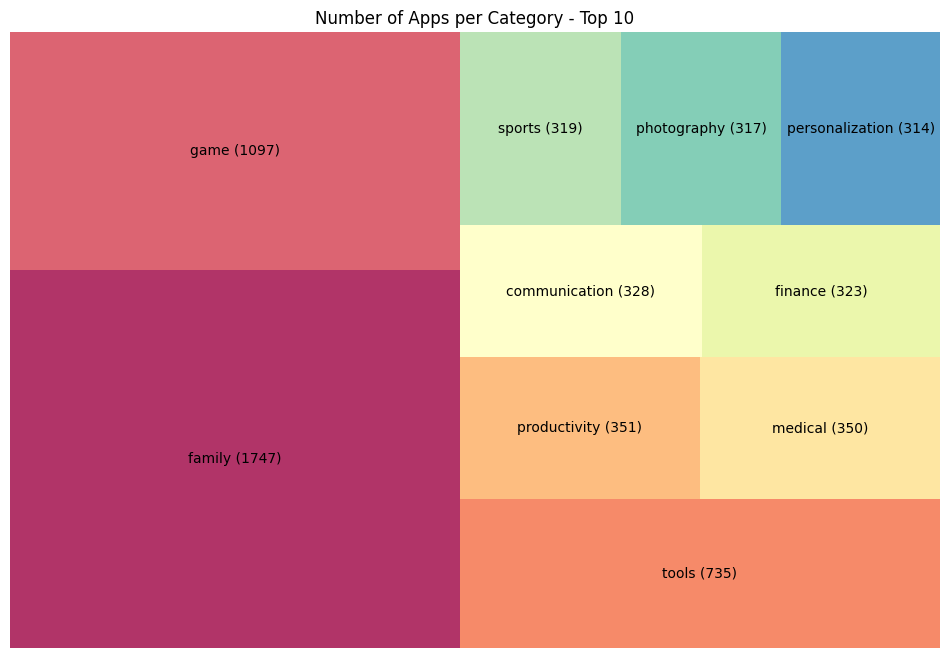

In [63]:
import matplotlib.pyplot as plt
import squarify

top_categories_counts = df['Category'].value_counts().nlargest(10)
labels = [f"{category} ({count})" for category, count in top_categories_counts.items()]
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=top_categories_counts, label=labels, color=colors, alpha=0.8)
plt.axis('off')
plt.title('Number of Apps per Category - Top 10')

plt.show()


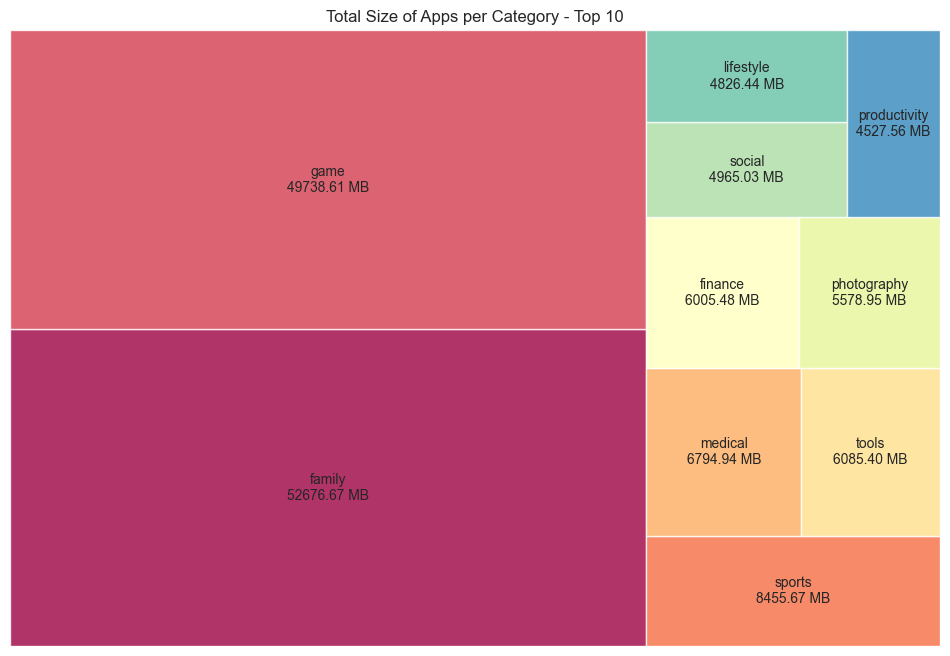

In [ ]:
import matplotlib.pyplot as plt
import squarify

category_size_sum = df.groupby('Category')['Size'].sum().nlargest(10)
labels = [f"{category}\n{size_sum:.2f} MB" for category, size_sum in category_size_sum.items()]
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

plt.figure(figsize=(12, 8))
squarify.plot(sizes=category_size_sum, label=labels, color=colors, alpha=0.8)
plt.axis('off')
plt.title('Total Size of Apps per Category - Top 10')
plt.show()


In [ ]:
# # print(df.to_string())
# df.to_csv("final/final_data.csv",index=False)

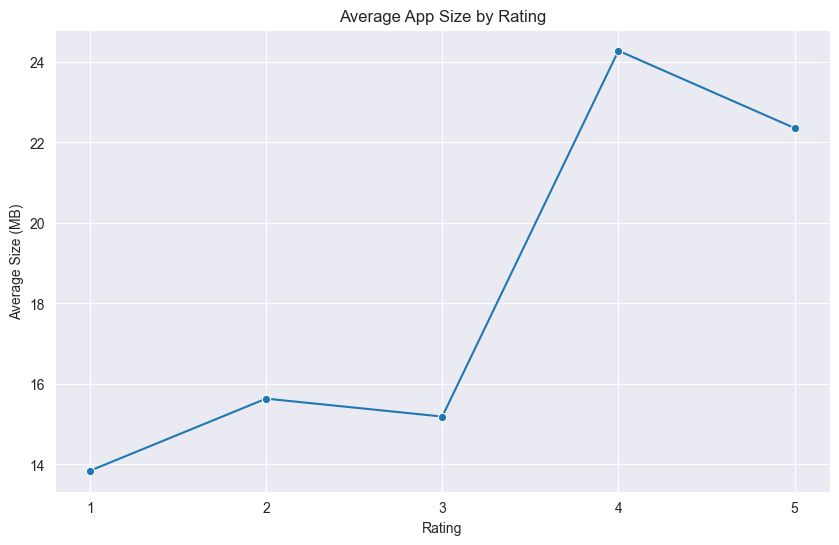

In [ ]:
df['Rounded Rating'] = df['Rating'].round()
average_size_by_rating = df.groupby('Rounded Rating')['Size'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='Rounded Rating', y='Size', data=average_size_by_rating, marker='o')
plt.title('Average App Size by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Size (MB)')
plt.xticks(average_size_by_rating['Rounded Rating'].unique())
plt.grid(True)
plt.show()


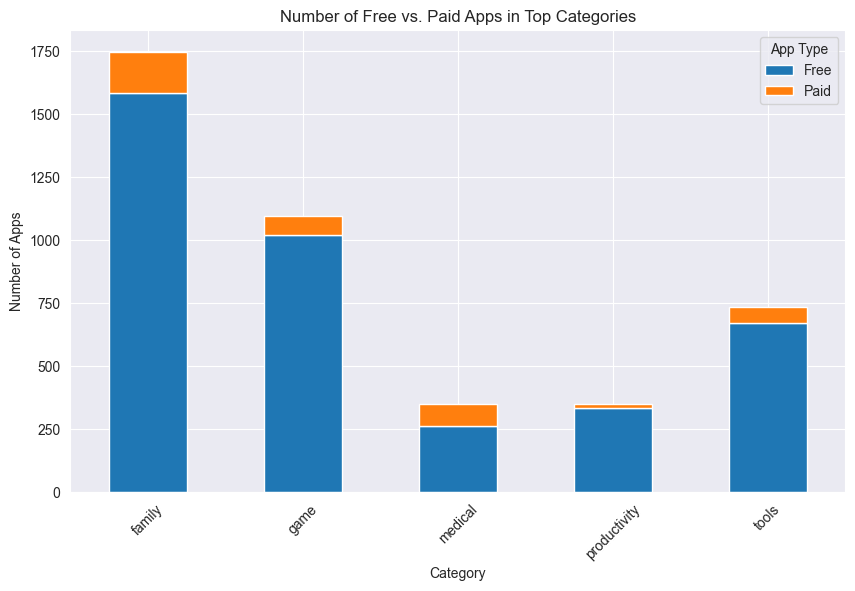

In [ ]:
df['App Type'] = df['Type'].apply(lambda x: 'Free' if x == 'free' else 'Paid')

top_categories = df['Category'].value_counts().nlargest(5).index
app_counts = df[df['Category'].isin(top_categories)].groupby(['Category', 'App Type']).size().unstack().fillna(0)

app_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Free vs. Paid Apps in Top Categories')
plt.xlabel('Category')
plt.ylabel('Number of Apps')
plt.xticks(rotation=45)
plt.show()


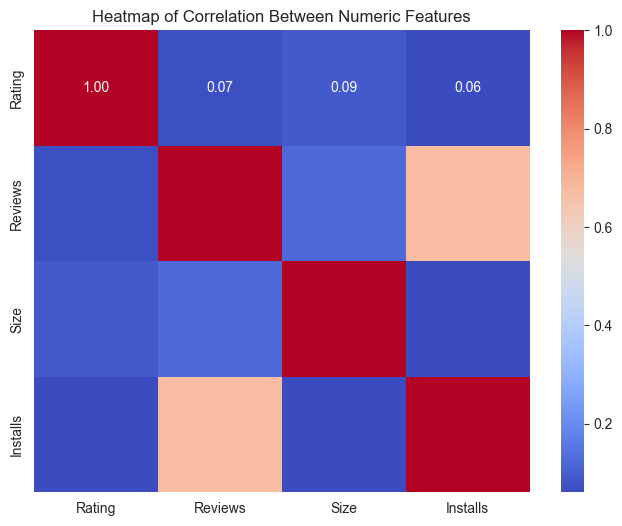

In [ ]:
numeric_features = df[['Rating', 'Reviews', 'Size', 'Installs']]

correlation_matrix = numeric_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Between Numeric Features')
plt.show()


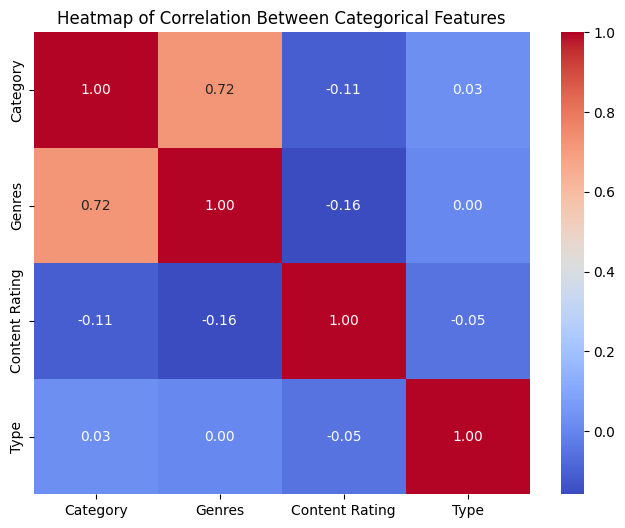

In [67]:
from sklearn.preprocessing import LabelEncoder

categorical_features = df[['Category', 'Genres', 'Content Rating', 'Type']]
le = LabelEncoder()
categorical_features = categorical_features.apply(le.fit_transform)

correlation_matrix = categorical_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Correlation Between Categorical Features')
plt.show()


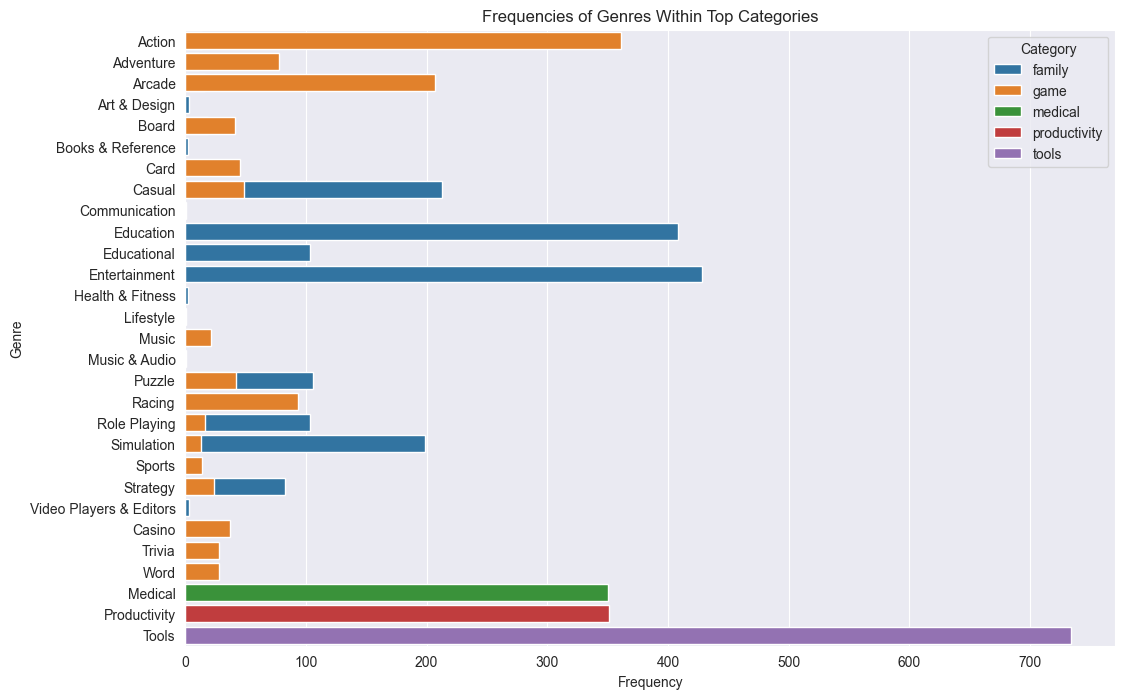

In [ ]:
df_expanded = df.drop('Genres', axis=1).join(df['Genres'].str.split(';', expand=True).stack().reset_index(level=1, drop=True).rename('Genre'))

genre_counts = df_expanded.groupby(['Category', 'Genre']).size().reset_index(name='Counts')

top_categories = df['Category'].value_counts().nlargest(5).index
genre_counts_filtered = genre_counts[genre_counts['Category'].isin(top_categories)]

plt.figure(figsize=(12, 8))
sns.barplot(x='Counts', y='Genre', hue='Category', data=genre_counts_filtered, dodge=False)
plt.title('Frequencies of Genres Within Top Categories')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.legend(title='Category')
plt.show()


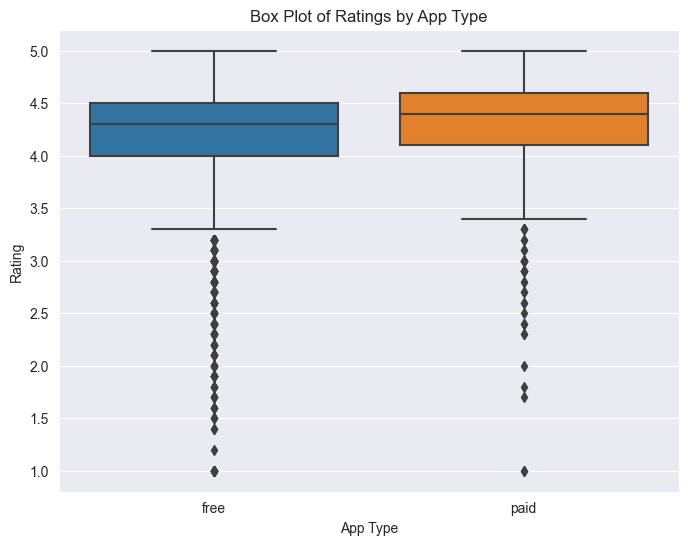

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Type', y='Rating', data=df)
plt.title('Box Plot of Ratings by App Type')
plt.xlabel('App Type')
plt.ylabel('Rating')
plt.show()


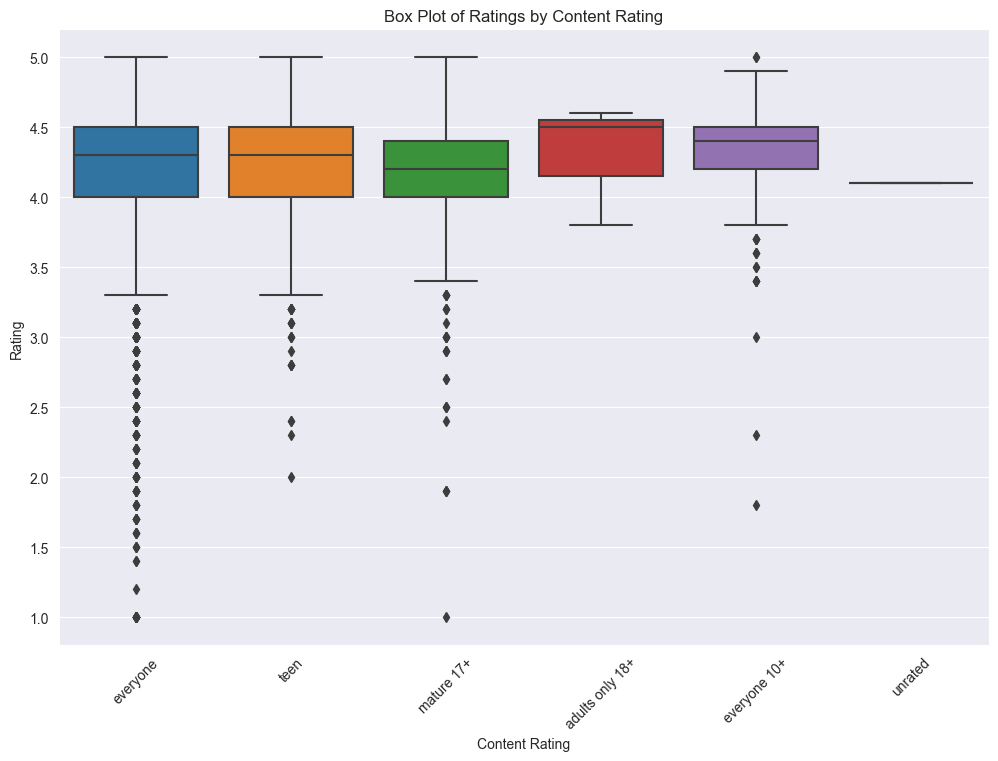

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Content Rating', y='Rating', data=df)
plt.title('Box Plot of Ratings by Content Rating')
plt.xticks(rotation=45)
plt.xlabel('Content Rating')
plt.ylabel('Rating')
plt.show()


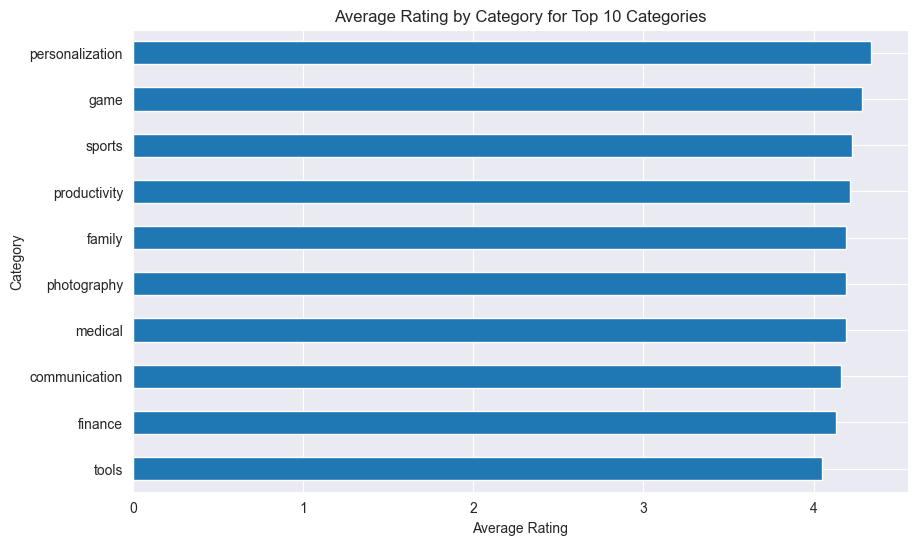

In [ ]:
top_categories = df['Category'].value_counts().nlargest(10).index
average_rating_by_category = df[df['Category'].isin(top_categories)].groupby('Category')['Rating'].mean().sort_values()

plt.figure(figsize=(10, 6))
average_rating_by_category.plot(kind='barh')
plt.title('Average Rating by Category for Top 10 Categories')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.show()


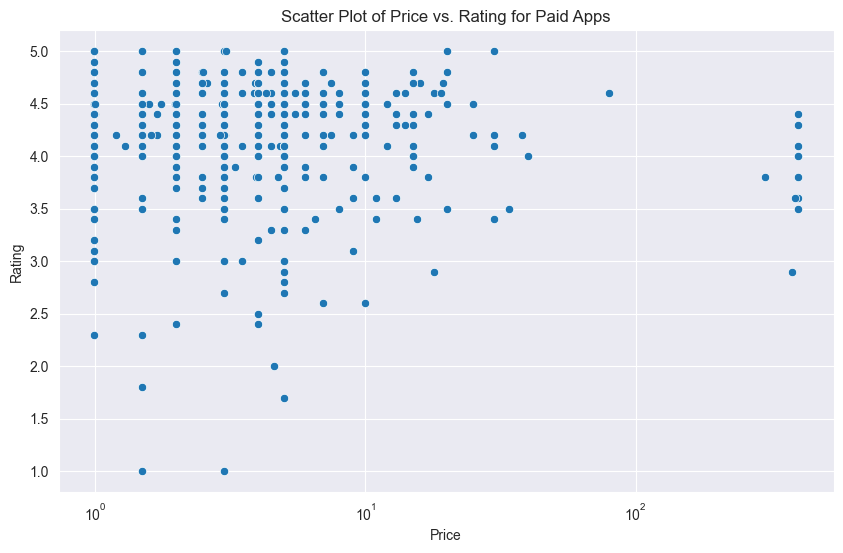

In [ ]:
paid_apps = df[df['Type'] == 'paid']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Rating', data=paid_apps)
plt.title('Scatter Plot of Price vs. Rating for Paid Apps')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.xscale('log') 
plt.show()


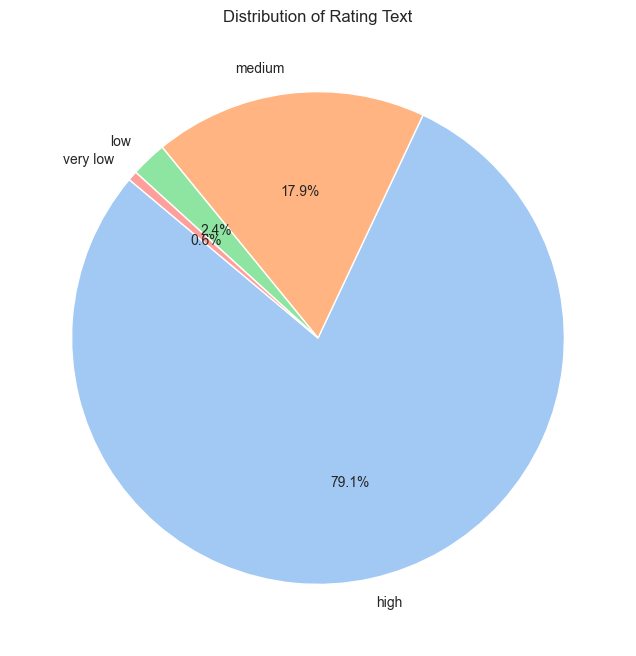

In [ ]:
rating_text_counts = df['Rating-Text'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(rating_text_counts, labels=rating_text_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Distribution of Rating Text')
plt.show()

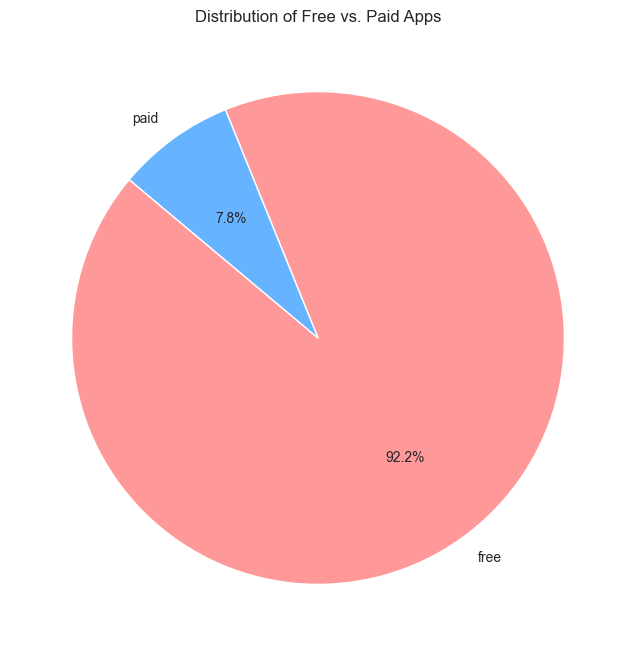

In [ ]:
app_type_counts = df['Type'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(app_type_counts, labels=app_type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Free vs. Paid Apps')
plt.show()

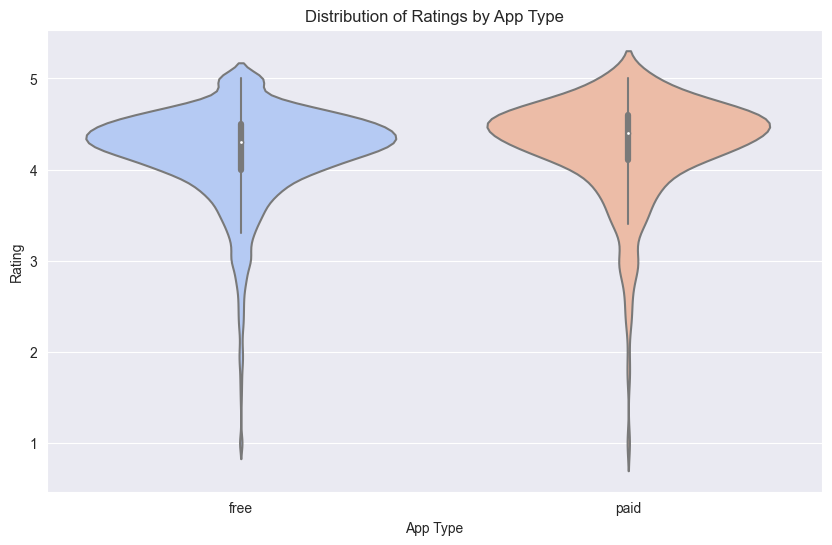

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Type', y='Rating', data=df, palette='coolwarm')
plt.title('Distribution of Ratings by App Type')
plt.xlabel('App Type')
plt.ylabel('Rating')
plt.show()


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_25744\2228296474.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Installs', y='Category', data=df, estimator=sum, ci=None, orient='h',errorbar=None)


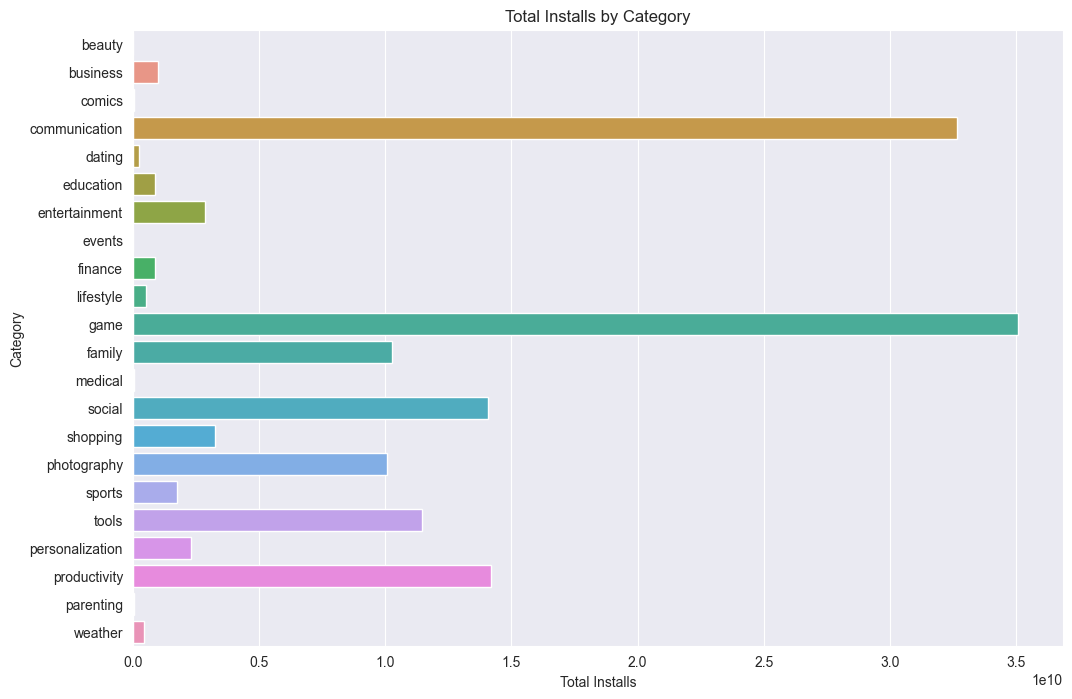

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Installs', y='Category', data=df, estimator=sum, ci=None, orient='h',errorbar=None)
plt.title('Total Installs by Category')
plt.xlabel('Total Installs')
plt.ylabel('Category')
plt.show()


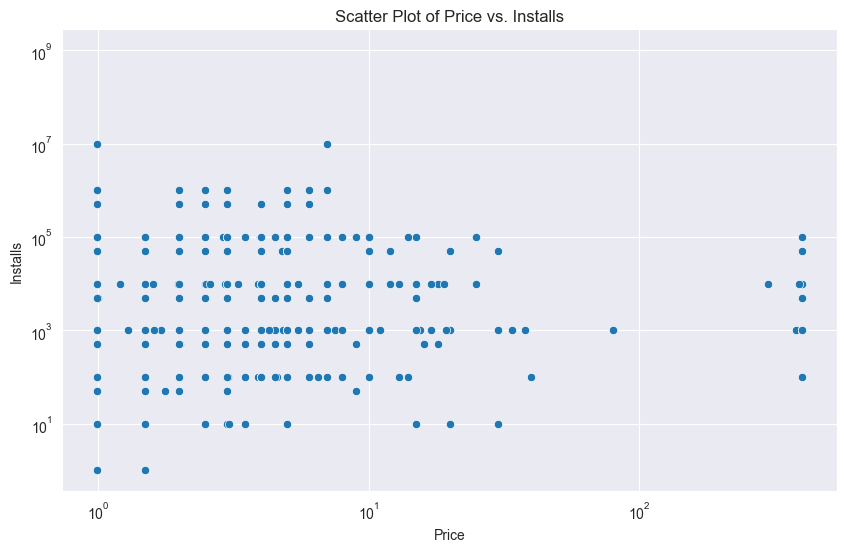

In [ ]:
# Draw a graph to represent relation between price and installs
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price', y='Installs', data=df)
plt.title('Scatter Plot of Price vs. Installs')
plt.xlabel('Price')
plt.ylabel('Installs')
plt.xscale('log')
plt.yscale('log')
plt.show()


In [ ]:
df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)


In [ ]:
df = df.rename(columns={'Content Rating': 'Content-Rating'})

In [ ]:
print(df.isnull().sum())

Unnamed: 0        0
App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content-Rating    0
Genres            0
Rating-Text       0
Rounded Rating    0
App Type          0
dtype: int64
